# Design Oriented Project - TextVQA Notebook for complete inference

by *Aman Shenoy, Alex Mathai, Megh Thakkar*

---

The following notebook is a complete inference of the current running TextVQA model, which we will use as a baseline. Most of the modules used were the same as mentioned in the paper, with the biggest difference as of now being the Feature Extraction methods and the basic Optical Character Recognition Module. The complete model has a lot of work remaining and the following is only a baseline TextVQA model which is prone to a lot of errors.

Along with this notebook a folder containing two pre-trained models and scripts has been shared. This shared folder should be kept inside the main directory of ones google drive and is referred to in the following code as `/content/drive/My Drive/TextVQA files/filename.ext`. All downloads and wgets in this notebook are directed towards the users Google Drive and are stored in the Drive folder.

To make sure that the notebook is clean and user friendly all source code is in the folder and not in the notebook, the source code can be examined if desired. A short note is put before each set of cells explaining its purpose in brief.

# Check System 

The following code cell installs GPU utilization checking libraries along with the line profiler extension for the notebook

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil psutil humanize
!pip install line_profiler
%load_ext line_profiler
import psutil, humanize, os, GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=a01d4c952f395005f4b78168b86ac273afb3d7a0b9599ee108118f6b6bf0d437
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


---
Check the available system and GPU resources


In [2]:
printm() 

Gen RAM Free: 26.3 GB  | Proc size: 159.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# Imports 

Few imports to be able to access Google Drive. The following cell will also require authorization which can be done by clicking on the link and simply copy-pasting the link in the space given on execution of the cell

In [28]:
from IPython.display import display, HTML, clear_output
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Downloads and other stuff 

The following cell downloads all the baseline pre-trained models and gets the repositories and binaries that have been used in the end to end  TextVQA model and puts them in the relevant directories for them to be accessable to all the code. All the downloads that happen below are directed to the users Google Drive home directory. 

This location can be changed but is not recommended as it will disrupt the whole process, as the scripts are already directed towards the folders in Drive.

Running this cell should take a considerable amount of time. Should take ~10 minutes in an optimal case for all the downloads, since a lot of the files being downloaded are quite large in size.

In [5]:
%cd /content/drive/'My Drive'

%mkdir model_data
!wget -O /content/drive/'My Drive'/model_data/answers_lorra.txt https://dl.fbaipublicfiles.com/pythia/data/answers_textvqa_more_than_1.txt
!wget -O /content/drive/'My Drive'/model_data/vocabulary_100k.txt https://dl.fbaipublicfiles.com/pythia/data/vocabulary_100k.txt
!wget -O /content/drive/'My Drive'/model_data/detectron_model.pth  https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.pth 
!wget -O /content/drive/'My Drive'/model_data/lorra.pth https://dl.fbaipublicfiles.com/pythia/pretrained_models/textvqa/lorra_best.pth
!wget -O /content/drive/'My Drive'/model_data/lorra.yaml https://dl.fbaipublicfiles.com/pythia/pretrained_models/textvqa/lorra.yml
!wget -O /content/drive/'My Drive'/model_data/detectron_model.yaml https://dl.fbaipublicfiles.com/pythia/detectron_model/detectron_model.yaml
!wget -O /content/drive/'My Drive'/model_data/detectron_weights.tar.gz https://dl.fbaipublicfiles.com/pythia/data/detectron_weights.tar.gz
!tar xf /content/drive/'My Drive'/model_data/detectron_weights.tar.gz

# Install dependencies
!pip install ninja yacs cython matplotlib demjson
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

%cd /content/drive/'My Drive'
%rm -rf fastText
!git clone https://github.com/facebookresearch/fastText.git fastText
%cd /content/drive/'My Drive'/fastText
!pip install .
!make

%cd /content/drive/'My Drive'/
%rm -rf pythia
!git clone https://github.com/facebookresearch/pythia.git pythia
%cd /content/drive/'My Drive'/pythia
!pip install -e .

%mkdir /content/drive/'My Drive'/pythia/pythia/.vector_cache
!wget -O /content/drive/'My Drive'/pythia/pythia/.vector_cache/wiki.en.bin https://dl.fbaipublicfiles.com/pythia/pretrained_models/fasttext/wiki.en.bin

# Install maskrcnn-benchmark to extract detectron features
%cd /content/drive/'My Drive'
!pip install pillow==6.0.0 transformers==2.1.0 
!git clone https://gitlab.com/meetshah1995/vqa-maskrcnn-benchmark.git
%cd /content/drive/'My Drive'/vqa-maskrcnn-benchmark
# Compile custom layers and build mask-rcnn backbone
!rm -rf build/
!python setup.py build develop
!cd ..

!cp -r /content/drive/'My Drive'/detectron /content/drive/'My Drive'/pythia/pythia
!wget -O -nc /content/drive/'My Drive'/glove.6B.zip http://nlp.stanford.edu/data/glove.6B.zip
!unzip /content/drive/'My Drive'/glove.6B.zip -d /content/drive/'My Drive'/
!cp /content/drive/My\ Drive/TextVQA\ files/tvqalib/* /content/

/content/drive/My Drive
mkdir: cannot create directory ‘model_data’: File exists
--2020-04-29 04:15:36--  https://dl.fbaipublicfiles.com/pythia/data/answers_textvqa_more_than_1.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4a8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32540 (32K) [text/plain]
Saving to: ‘/content/drive/My Drive/model_data/answers_lorra.txt’

/content/drive/My D 100%[===================>]  31.78K  --.-KB/s    in 0.08s   

2020-04-29 04:15:37 (414 KB/s) - ‘/content/drive/My Drive/model_data/answers_lorra.txt’ saved [32540/32540]

--2020-04-29 04:15:39--  https://dl.fbaipublicfiles.com/pythia/data/vocabulary_100k.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4a8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.co

--2020-04-29 04:21:56--  https://dl.fbaipublicfiles.com/pythia/pretrained_models/fasttext/wiki.en.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4a8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8493673445 (7.9G) [application/octet-stream]
Saving to: ‘/content/drive/My Drive/pythia/pythia/.vector_cache/wiki.en.bin’

/content/drive/My D  17%[==>                 ]   1.36G  18.2MB/s    in 60s     

2020-04-29 04:22:57 (23.2 MB/s) - Read error at byte 1464575066/8493673445 (Connection reset by peer). Retrying.

--2020-04-29 04:22:58--  (try: 2)  https://dl.fbaipublicfiles.com/pythia/pretrained_models/fasttext/wiki.en.bin
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 8493673445 (7.9G), 7029098379 (6.5G

fatal: destination path 'vqa-maskrcnn-benchmark' already exists and is not an empty directory.
/content/drive/My Drive/vqa-maskrcnn-benchmark
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/maskrcnn_benchmark
copying maskrcnn_benchmark/__init__.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark
creating build/lib.linux-x86_64-3.6/maskrcnn_benchmark/config
copying maskrcnn_benchmark/config/__init__.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/config
copying maskrcnn_benchmark/config/defaults.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/config
copying maskrcnn_benchmark/config/paths_catalog.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/config
creating build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data
copying maskrcnn_benchmark/data/__init__.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data
copying maskrcnn_benchmark/data/build.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/data
copying

# TextVQA execution


The following is the execute function that performs point estimation on a particular example.
  
 As visible below the line `from tvqa import *` is equivalent to having all the code in the form of cells, as an import statement interprets the whole script (*if not put together with* `if __name__ == '__main__'`)
  
The function is additionally written in this manner so that the line profiler can run on it in such a way that we can identify bottlenecks in the running of the code more effeciently. 

In [0]:
 import sys, subprocess
 from tvqa import *

def execute(image_url, question):
  clear_output()
  demo = LoRRADemo()
  image_path = demo.get_actual_image(image_url)
  image = Image.open(image_path)
  demo.init_ocr_processor()
  demo.dump_glove_vectors(image_url)
  
  print("Building...")
  demo.build()
  
  print("Predicting...")
  scores, predictions = demo.predict(image_url, question)
  
  scores = [score * 100 for score in scores]
  del demo
  df = pd.DataFrame({"Prediction": predictions, "Confidence": scores})
  td = TextDetection()
  boxed_image = td.display(image_url, './')
  display(boxed_image)
  print("Question:", question)
  display(HTML(df.to_html()))
  gc.collect()
  torch.cuda.empty_cache()

# TextVQA Interactive Tests

The following cells are a demonstration of the baseline. Running it for the first time should also trigger a ~5 minute download that happens for initializing `pythia`. Since we did not want to tamper with any of the cloned repositories, we allow this one time download. 

Most of the modules in this model are that mentioned in the paper and show state-of-the-art performance on their respective tasks. The following code has accumalated all the modules and their pre-trained weights and incorporated that with our current functional optical character recognition module. 

As mentioned before, the model performance is not remarkable because of (a) The following is only the baseline, which is being built on extensively and (b) TextVQA is a remarkably hard task, with even state of the art models bragging only a ~30% accuracy. Even given these drawbacks, the model still performs fairly well on simple questions. 

---
Below we can see a few demonstrated examples. The model can also be tested on a users image of choice (provided by link) and question of choice (replace variable 'question'). The results display -  

*1.) The image with the detected text boxed*  
*2.) The question*   
*3.) The top 5 answers and their confidence scores*  


In [4]:
image_link = 'https://ilovecuriosity.files.wordpress.com/2013/03/britelite700.jpg'
question = "what shop is this" 

path_to_image = '/content/inference.jpg'
subprocess.check_output('wget -O ' + path_to_image + ' ' + image_link, shell = True)
execute(path_to_image, question)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
image_link = 'https://i.pinimg.com/originals/95/0e/bc/950ebc736e441017b0987295be266b3d.jpg'
question = "what colour is the bike on the front" 

path_to_image = '/content/inference.jpg'
subprocess.check_output('wget -O ' + path_to_image + ' ' + image_link, shell = True)
execute(path_to_image, question)

Output hidden; open in https://colab.research.google.com to view.

OCR tokens returned by the module ['whitfield', 'paxton', '8', '93', '93', 'sow']
Dumped glove vectors for OCR tokens
Building...
Intializing processors...
Building pythia...
Building detection model...
Building resnet...
Predicting...


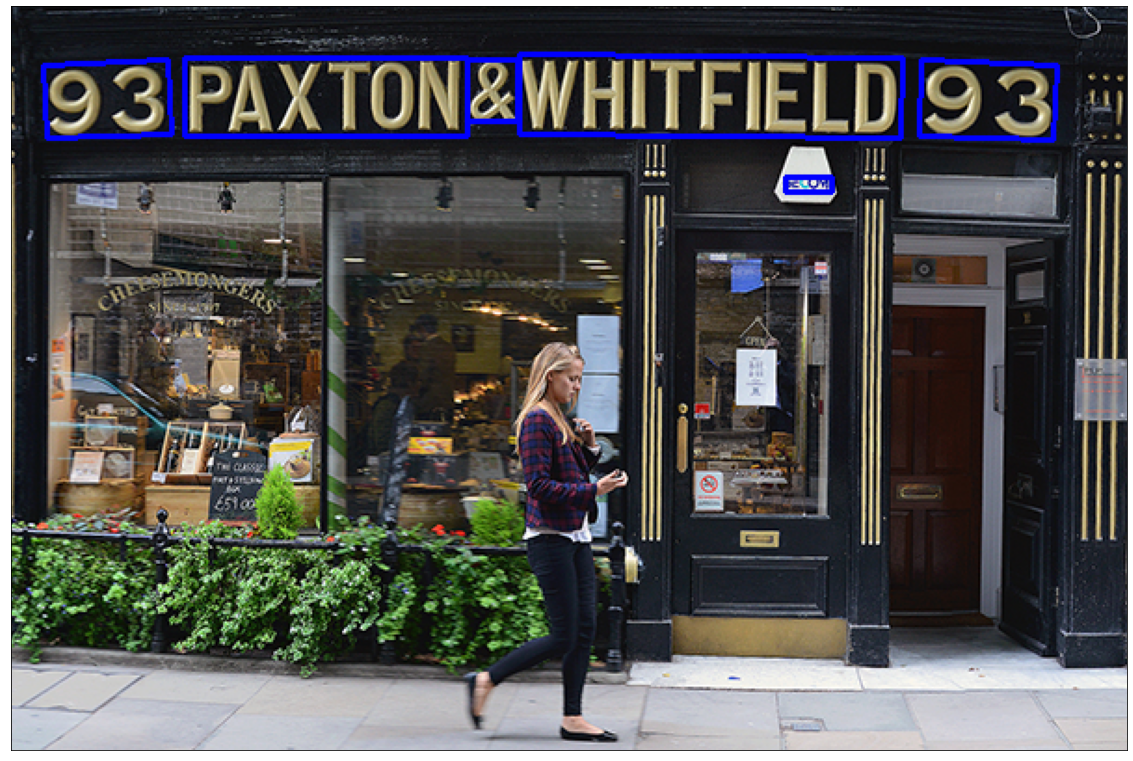

None

Question: what color is her hair


,Prediction,Confidence
0,answering does not require reading text in the image,99.838233
1,white,0.140229
2,yellow,0.013732
3,green,0.005202
4,not a question,0.001069


In [13]:
image_link = 'https://3tsll33cscvk11pae33oze51-wpengine.netdna-ssl.com/wp-content/uploads/2014/04/london-shopping-jermyn-street.png'
question = "what color is her hair" 

path_to_image = '/content/inference.jpg'
subprocess.check_output('wget -O ' + path_to_image + ' ' + image_link, shell = True)
execute(path_to_image, question)